In [542]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import itertools
import math
import warnings
warnings.filterwarnings("ignore")

In [490]:
def test_stationarity(ts, window = 12, xlabels = []):
    ma = ts.rolling(window=window).mean()
    mstd = ts.rolling(window=window).std()

    fig, ax = plt.subplots(figsize=(15,5))
    plt.title('Rolling Mean & Standard Deviation')

    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(ma, color='orange', label='Rolling Mean')
    std = plt.plot(mstd, color='darkgreen', label = 'Rolling Std')
    plt.legend()
    plt.tight_layout()

    if len(xlabels):
        xticks = np.arange(0, len(xlabels), 1)
        ax.set_xticks(xticks, list(xlabels))
        plt.xticks(rotation=90)

    results = adfuller(ts, autolag='AIC')
    print('Dickey-Fuller Test Results:')
    print('Test Statistic: {0:.3f}'.format(results[0]))
    print('P-value: {0:.3f}'.format(results[1]))

In [515]:
def tsplot(ts, figsize=(15,10)):
    
    fig = plt.figure(figsize=figsize)
    layout = (3,1)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (2, 0))

    xticks = np.arange(0, 20, 1)
    xlabels = ['{0:.0f}'.format(x) for x in xticks]
    acf_ax.set_xticks(xticks, labels=xlabels)
    pacf_ax.set_xticks(xticks, labels=xlabels)
    
    ts.plot(ax=ts_ax)
    ts_ax.set_title('Time Series')
    smt.graphics.plot_acf(ts, ax=acf_ax)
    smt.graphics.plot_pacf(ts, ax=pacf_ax)
    plt.tight_layout()


In [441]:
def seasonal_decompose(y, figsize=(15,10), period = 12, model = 'multiplicative'):
    fig = sm.tsa.seasonal_decompose(y,period = period, model = model).plot()
    fig.set_size_inches(figsize)
    plt.tight_layout()

In [360]:
month_dict = {
    'Jan':1,
    'Feb':2,
    'Mar':3,
    'Apr':4,
    'May':5,
    'Jun':6,
    'Jul':7,
    'Aug':8,
    'Sep':9,
    'Oct':10,
    'Nov':11,
    'Dec':12
}

In [453]:
data = pd.read_csv('Air Pax Traffic Statistics (30).csv')
data['Month'] = data['Month'].apply(lambda x: month_dict[x])
data['Pax'] = data['Pax'].str.replace(',','').astype(int)
data_full = data.groupby(['Year','Month']).sum()['Pax'].reset_index()
data_full['Date'] = df['Month'].astype(str) + '-' + df['Year'].astype(str)
df = data_full[data_full['Year'] <= 2019]

Dickey-Fuller Test Results:
Test Statistic: -0.384
P-value: 0.913


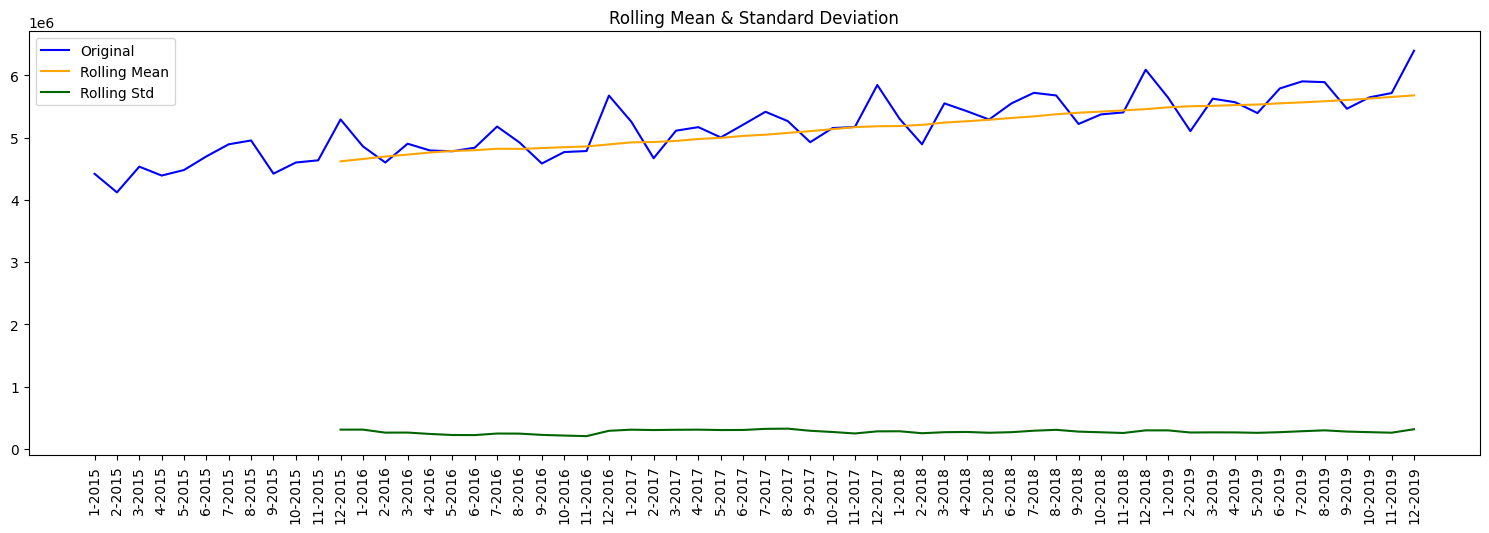

In [493]:
test_stationarity(df['Pax'], xlabels = df['Date'])

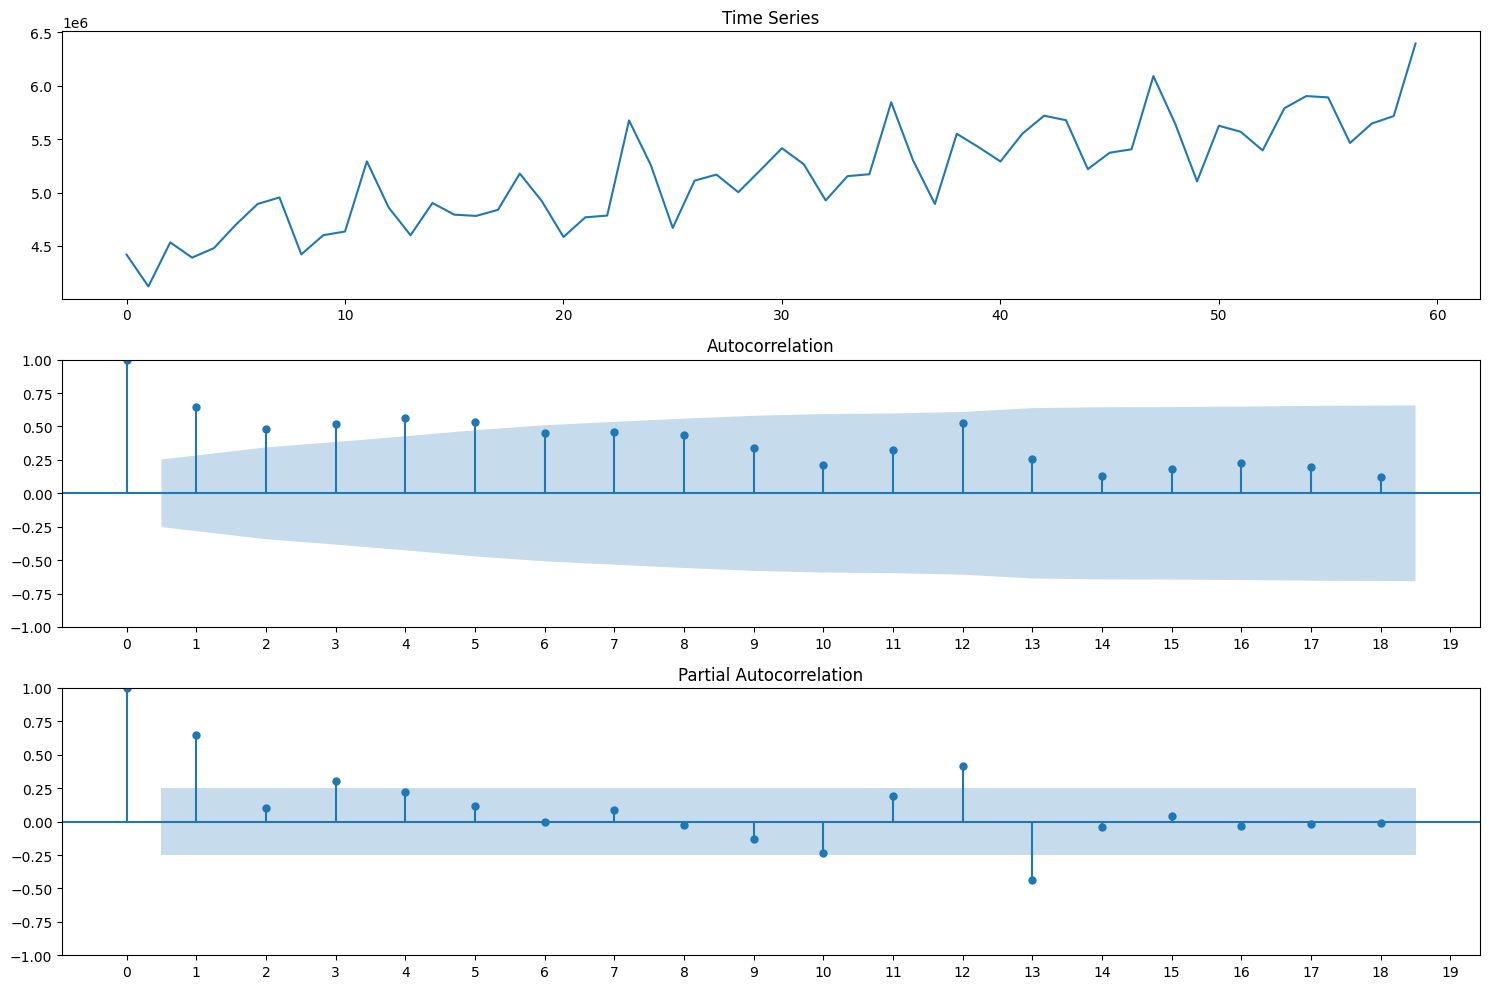

In [516]:
tsplot(df['Pax'])

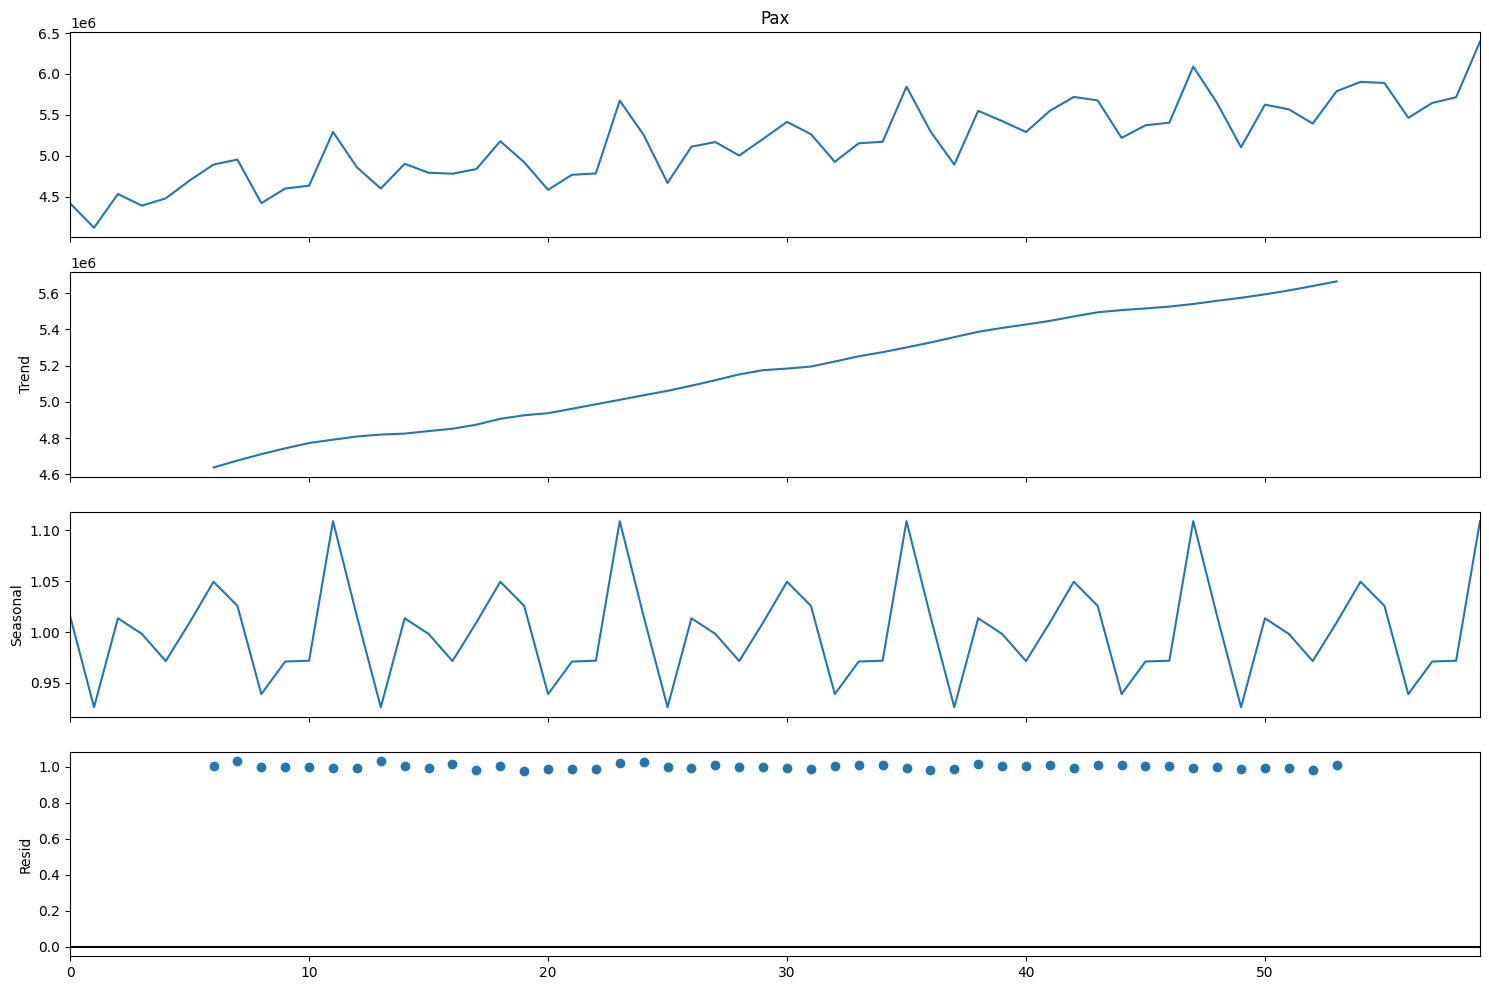

In [517]:
seasonal_decompose(df['Pax'])

In [519]:
data_diff = df['Pax'].diff()
data_diff = data_diff.dropna()

Dickey-Fuller Test Results:
Test Statistic: -2.967
P-value: 0.038


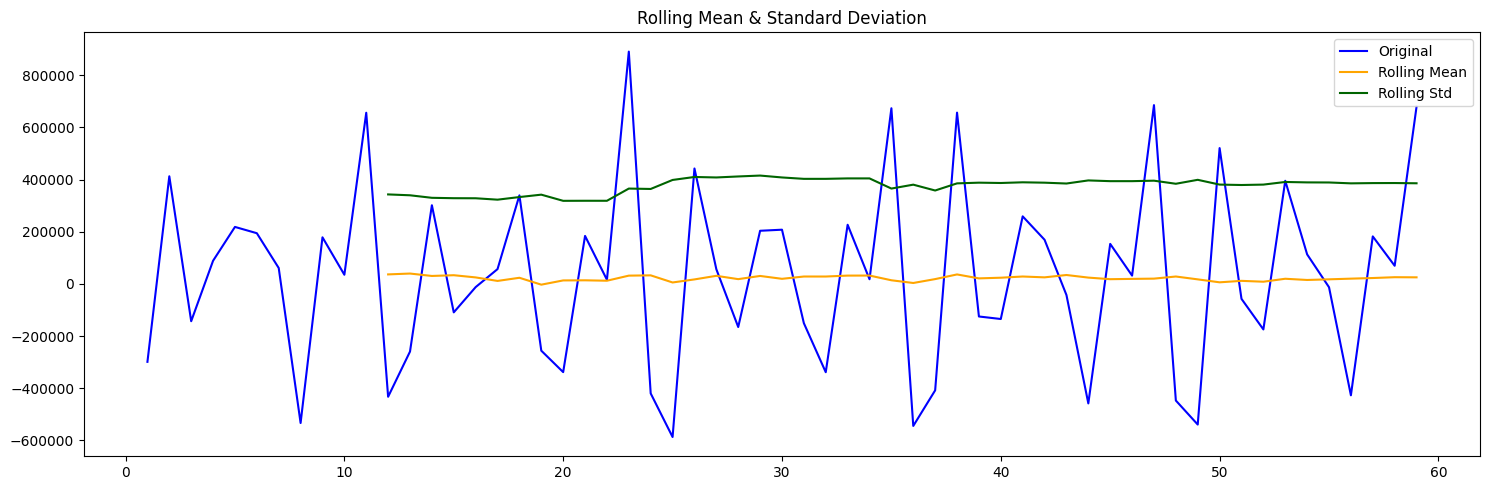

In [522]:
test_stationarity(data_diff)

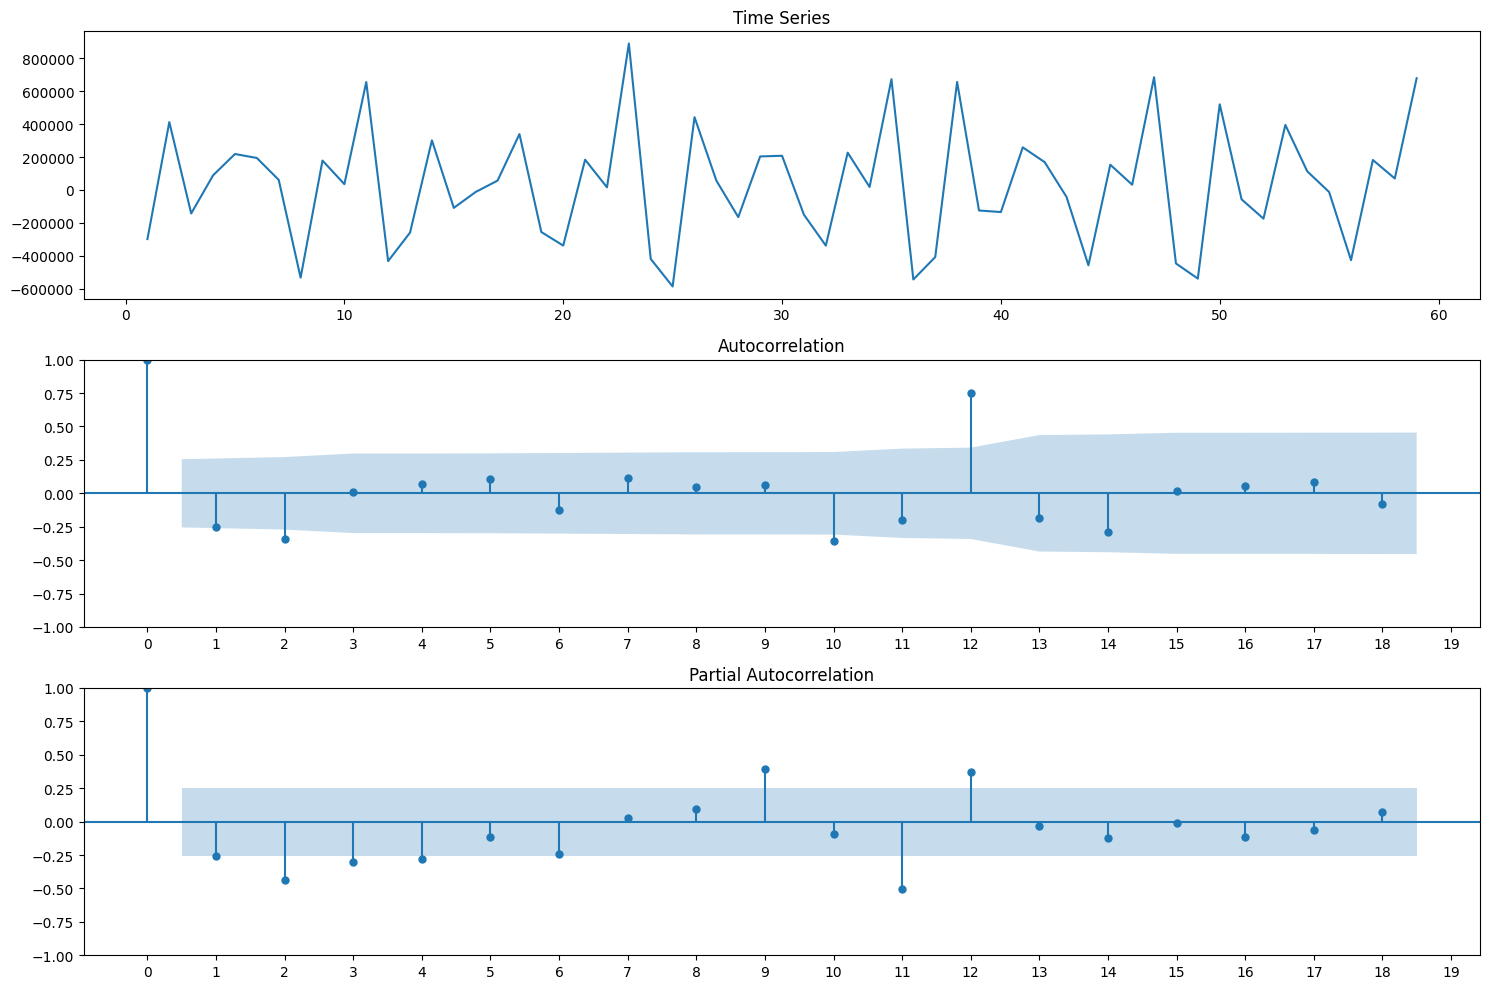

In [523]:
tsplot(data_diff)

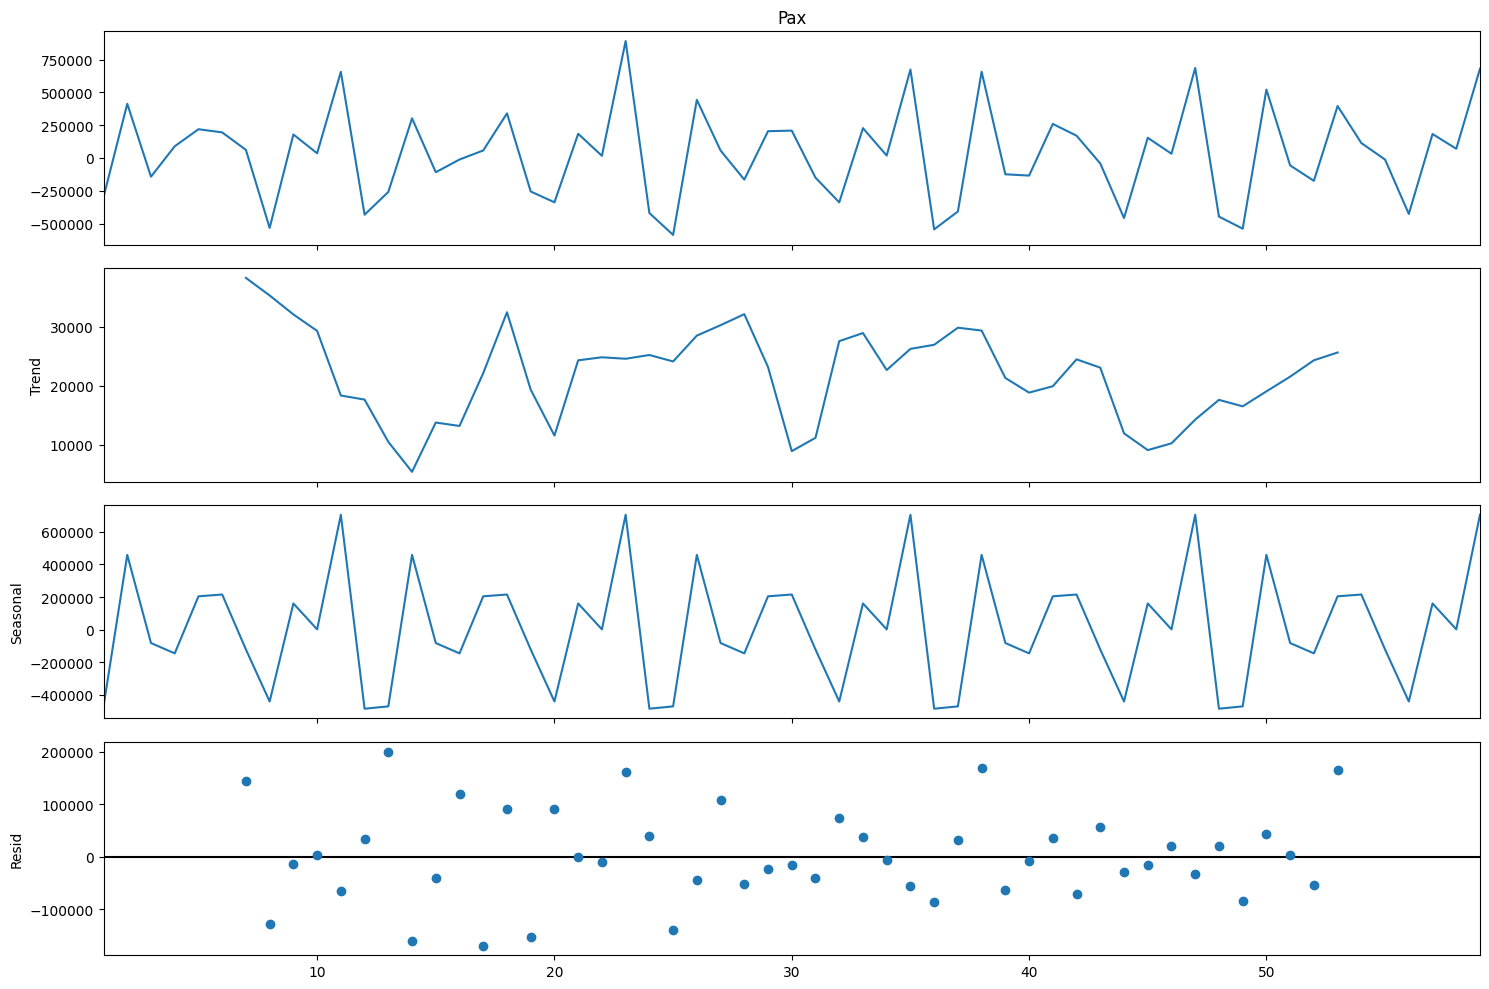

In [526]:
seasonal_decompose(data_diff, model = 'additive')

In [527]:
data_diff_seas = data_diff.diff(12)
data_diff_seas = data_diff_seas.dropna()

Dickey-Fuller Test Results:
Test Statistic: -5.067
P-value: 0.000


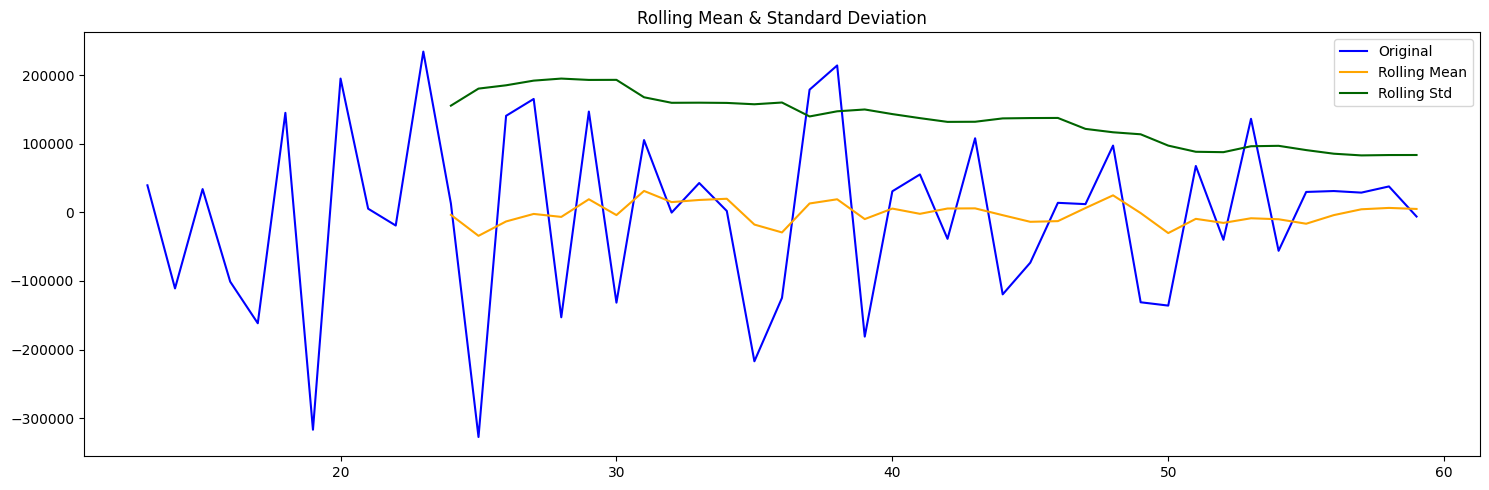

In [529]:
test_stationarity(data_diff_seas)

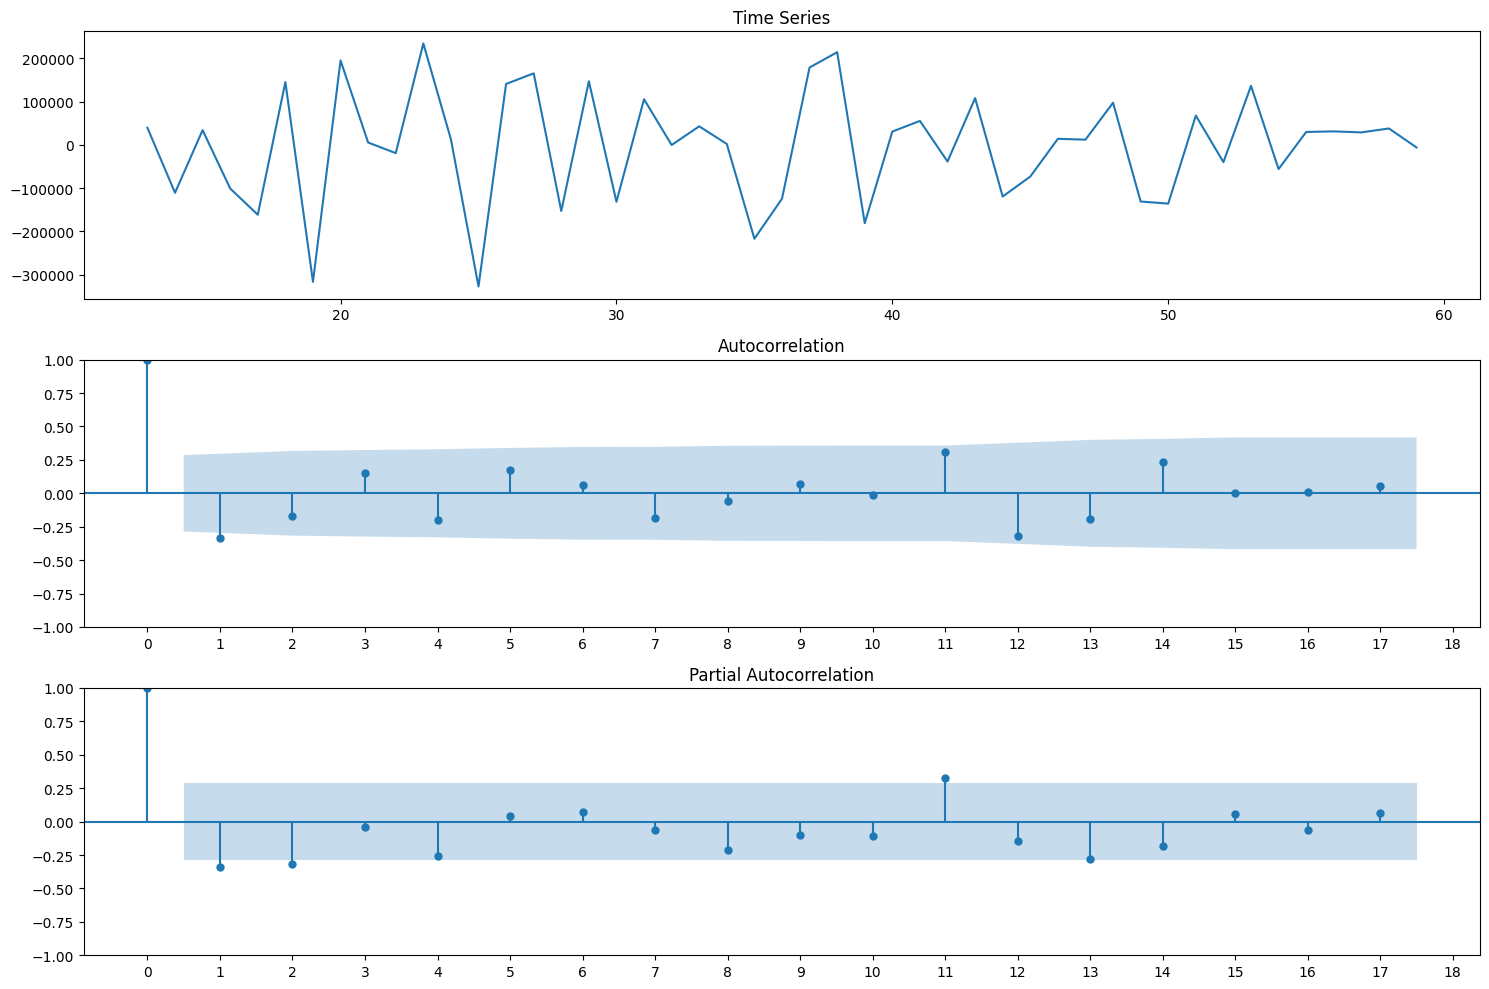

In [530]:
tsplot(data_diff_seas)

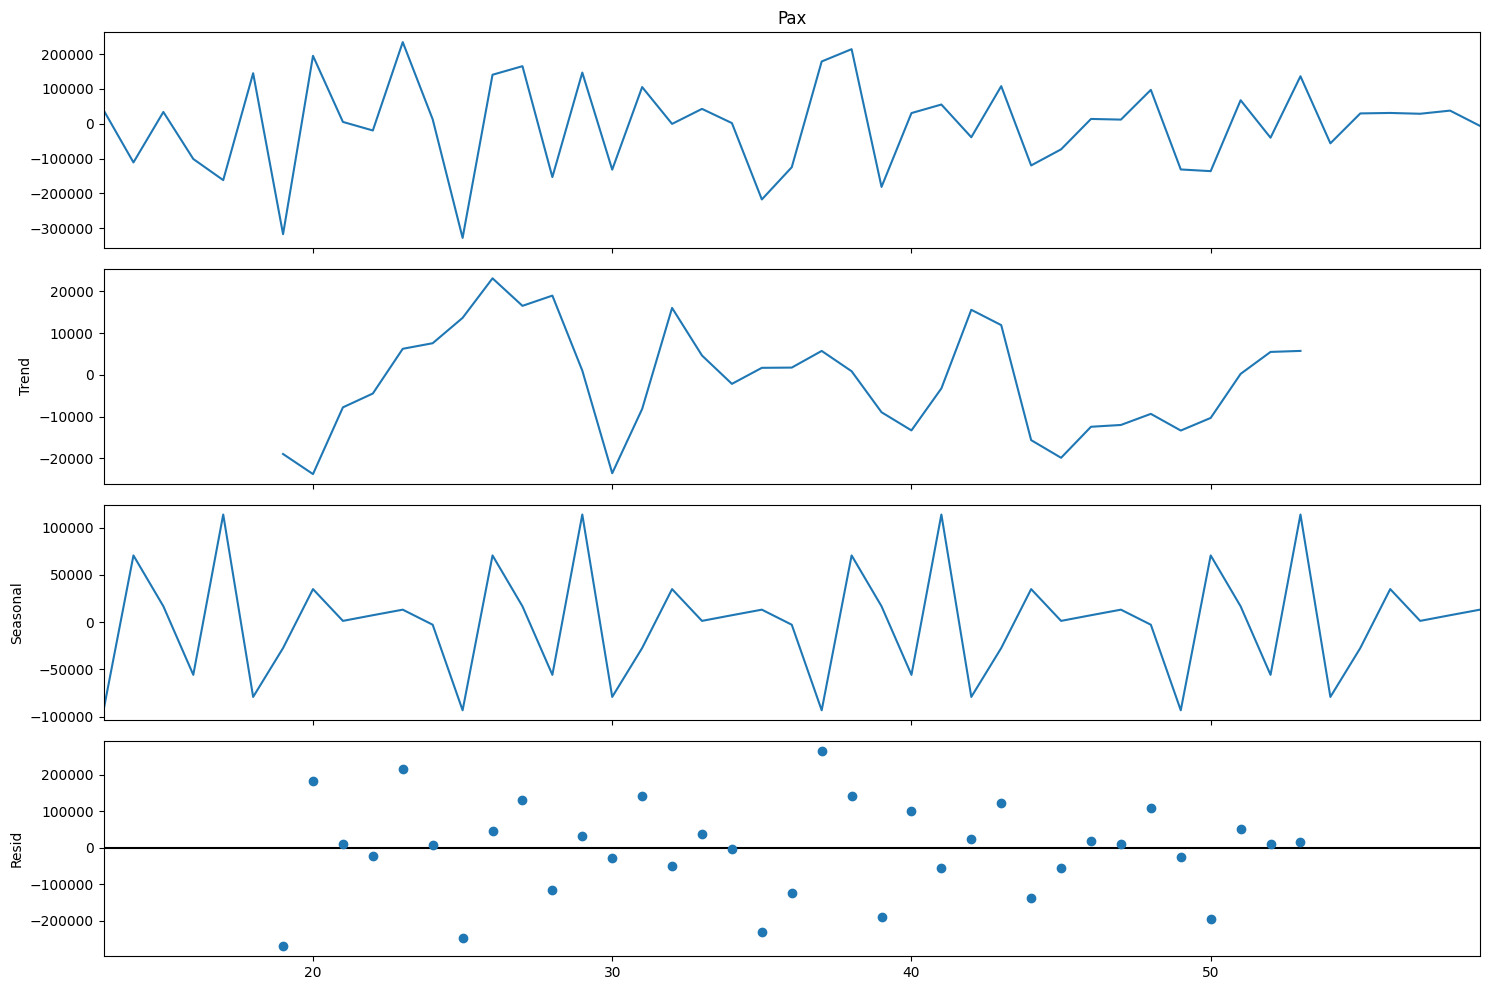

In [531]:
seasonal_decompose(data_diff_seas, model = 'additive')

In [557]:
train_len = int(len(df) * 0.8)
train, test = df[:train_len], df[train_len:]

In [609]:
# Define the range of values for p, d, q, P, D, Q, and m
p_values = range(0, 3)  # Autoregressive order
d_values = [0]          # Differencing order
q_values = range(0, 3)  # Moving average order
P_values = range(0, 2)  # Seasonal autoregressive order
D_values = range(0, 1)  # Seasonal differencing order
Q_values = range(0, 2)  # Seasonal moving average order
m_values = [12]         # Seasonal period

param_combinations = list(itertools.product(p_values, 
                                            d_values, 
                                            q_values, 
                                            P_values, 
                                            D_values, 
                                            Q_values, 
                                            m_values))

best_aic = float("inf")  
best_params_aic = None

best_rmse = float("inf")
best_params_rmse = None

for params in param_combinations:
    order = params[:3]
    seasonal_order = params[3:]
    
    try:
        model = sm.tsa.SARIMAX(train['Pax'], 
                               order=order, 
                               seasonal_order=seasonal_order)
        result = model.fit(disp=False)
        aic = result.aic

        forecast = result.get_forecast(steps=len(test))
        rmse = np.sqrt(np.mean((forecast.predicted_mean - test['Pax'])**2))
        
        # Ensure the convergence of the model
        if not math.isinf(result.zvalues.mean()):
            
            print('Order: {} Seasonal Order: {} AIC: {:.2f} RMSE: {:.2f}'.format(order, seasonal_order, aic, rmse))
        
            if aic < best_aic:
                best_aic = aic
                best_params_aic = params

            if rmse < best_rmse:
                best_rmse = rmse
                best_params_rmse = params
                
        else:
            print('Order: {} Seasonal Order: {} Unable to converge.'.format(order, seasonal_order))
            print(order, seasonal_order, 'not converged')

    except:
        continue

print("\nBest Parameters Based on AIC: {} AIC: {:.2f}".format(best_params_aic, best_aic))
print("\nBest Parameters Based on RMSE: {} AIC: {:.2f}".format(best_params_aic, best_rmse))

Order: (0, 0, 0) Seasonal Order: (0, 0, 0, 12) AIC: 1620.06 RMSE: 5686143.02
Order: (0, 0, 0) Seasonal Order: (0, 0, 1, 12) AIC: 1782.82 RMSE: 3395843.30
Order: (0, 0, 0) Seasonal Order: (1, 0, 0, 12) AIC: 1536.47 RMSE: 236310.09
Order: (0, 0, 0) Seasonal Order: (1, 0, 1, 12) AIC: 1550.49 RMSE: 191683.19
Order: (0, 0, 1) Seasonal Order: (0, 0, 0, 12) AIC: 1590.31 RMSE: 5482923.16
Order: (0, 0, 1) Seasonal Order: (0, 0, 1, 12) AIC: 1588.55 RMSE: 4035672.10
Order: (0, 0, 1) Seasonal Order: (1, 0, 0, 12) AIC: 1587.00 RMSE: 2996543.92
Order: (0, 0, 1) Seasonal Order: (1, 0, 1, 12) AIC: 1588.80 RMSE: 2837512.41
Order: (0, 0, 2) Seasonal Order: (0, 0, 0, 12) AIC: 1585.32 RMSE: 5352157.97
Order: (0, 0, 2) Seasonal Order: (0, 0, 1, 12) AIC: 1586.34 RMSE: 4378511.04
Order: (0, 0, 2) Seasonal Order: (1, 0, 0, 12) AIC: 1586.03 RMSE: 3858286.15
Order: (0, 0, 2) Seasonal Order: (1, 0, 1, 12) AIC: 1587.89 RMSE: 3630992.43
Order: (1, 0, 0) Seasonal Order: (0, 0, 0, 12) AIC: 1371.56 RMSE: 464771.85
Or

In [649]:
model = sm.tsa.statespace.SARIMAX(train['Pax'],order = best_params_aic[:3],seasonal_order = best_params_aic[3:])
model_fit = model.fit()
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                 Pax   No. Observations:                   48
Model:             SARIMAX(1, 0, 2)x(1, 0, [], 12)   Log Likelihood                -657.699
Date:                             Wed, 12 Feb 2025   AIC                           1325.399
Time:                                     15:29:36   BIC                           1334.755
Sample:                                          0   HQIC                          1328.934
                                              - 48                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9985      0.012     84.207      0.000       0.975       1.022
ma.L1         -0.5156      

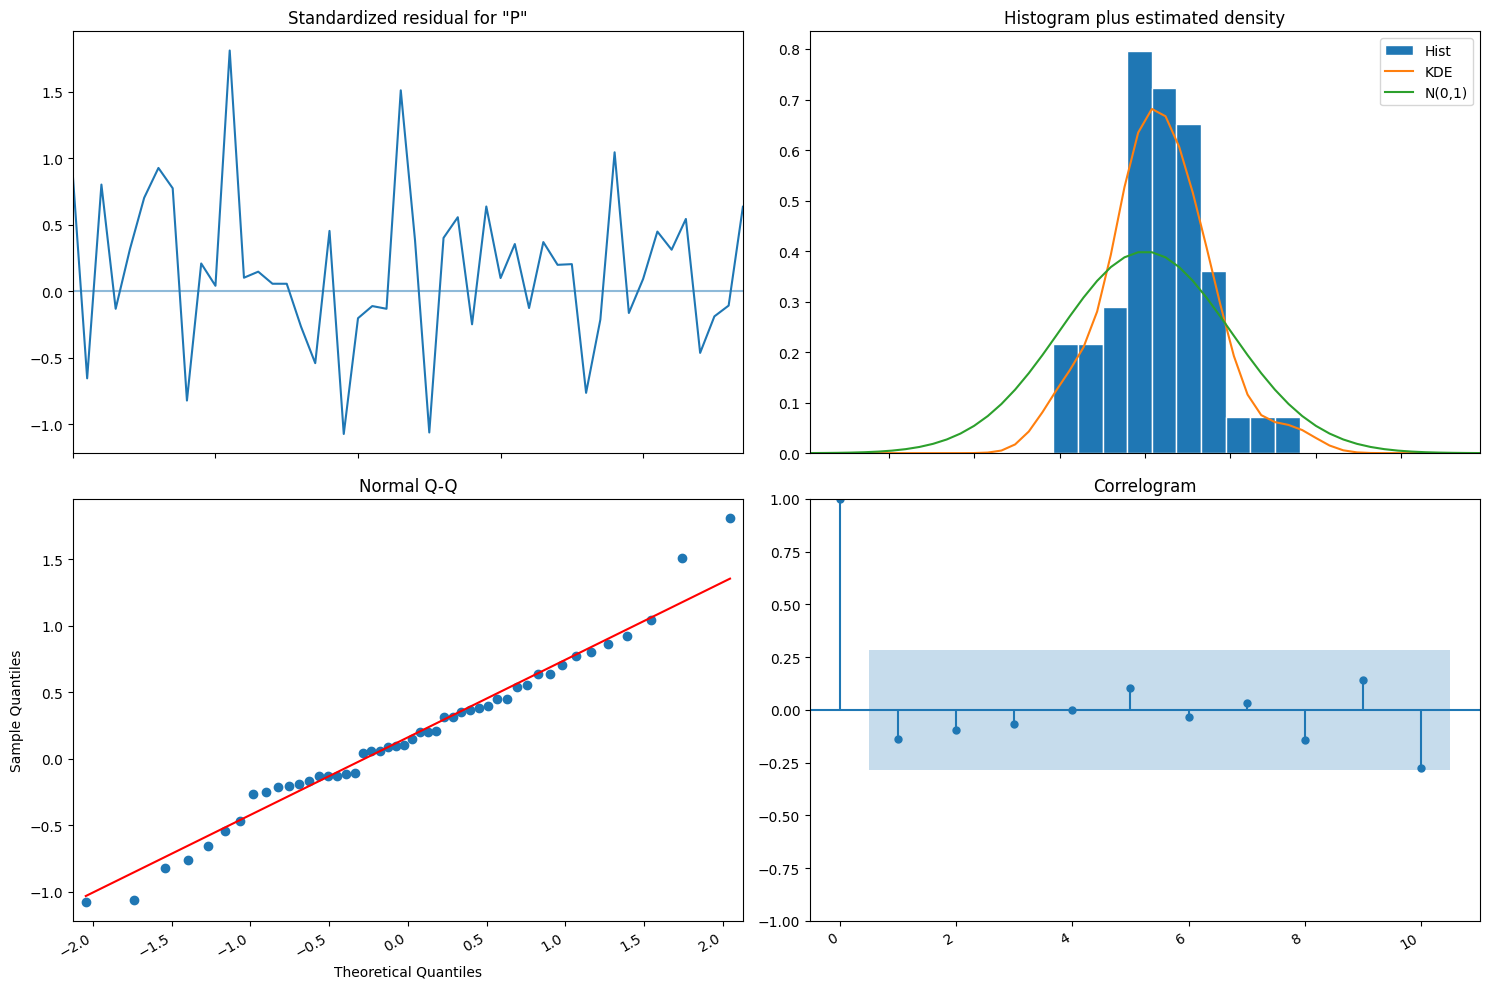

In [650]:
fig = model_fit.plot_diagnostics(figsize=(15, 10))
fig.autofmt_xdate()
plt.tight_layout()

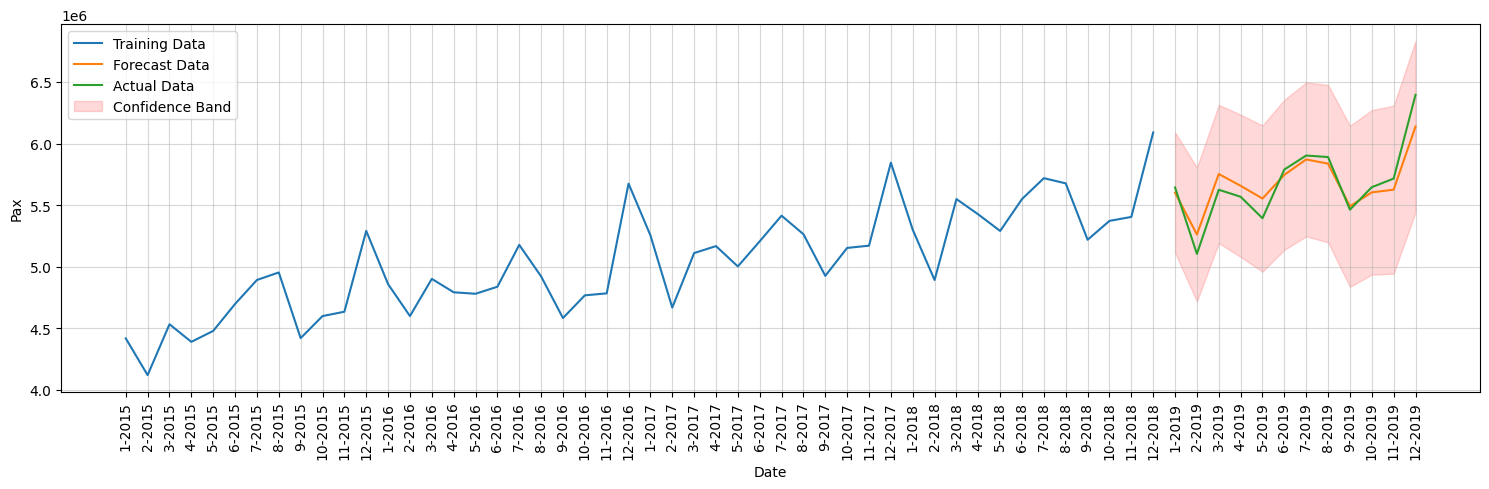

In [651]:
forecast = model_fit.get_forecast(steps=len(test))
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

ax = train['Pax'].plot(figsize=(15,5))
forecast_values.plot()
test['Pax'].plot(ax=ax)
plt.fill_between(forecast_values.index, 
                 confidence_intervals['lower Pax'], 
                 confidence_intervals['upper Pax'], 
                 color='red',
                 alpha=0.15)
plt.legend(['Training Data', 
            'Forecast Data', 
            'Actual Data',
            'Confidence Band'], 
           loc='upper left')

xlabels = df['Date']
xticks = np.arange(0, len(xlabels), 1)
ax.set_xticks(xticks, list(xlabels))
plt.xticks(rotation=90)

plt.xlabel('Date')
plt.ylabel('Pax')
plt.grid(alpha=0.5)
plt.tight_layout()

In [652]:
model = sm.tsa.statespace.SARIMAX(df['Pax'],order = best_params_aic[:3],seasonal_order = best_params_aic[3:])
model_fit = model.fit()
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                 Pax   No. Observations:                   60
Model:             SARIMAX(1, 0, 2)x(1, 0, [], 12)   Log Likelihood                -819.352
Date:                             Wed, 12 Feb 2025   AIC                           1648.703
Time:                                     15:29:37   BIC                           1659.175
Sample:                                          0   HQIC                          1652.799
                                              - 60                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9984      0.012     85.649      0.000       0.976       1.021
ma.L1         -0.4899      

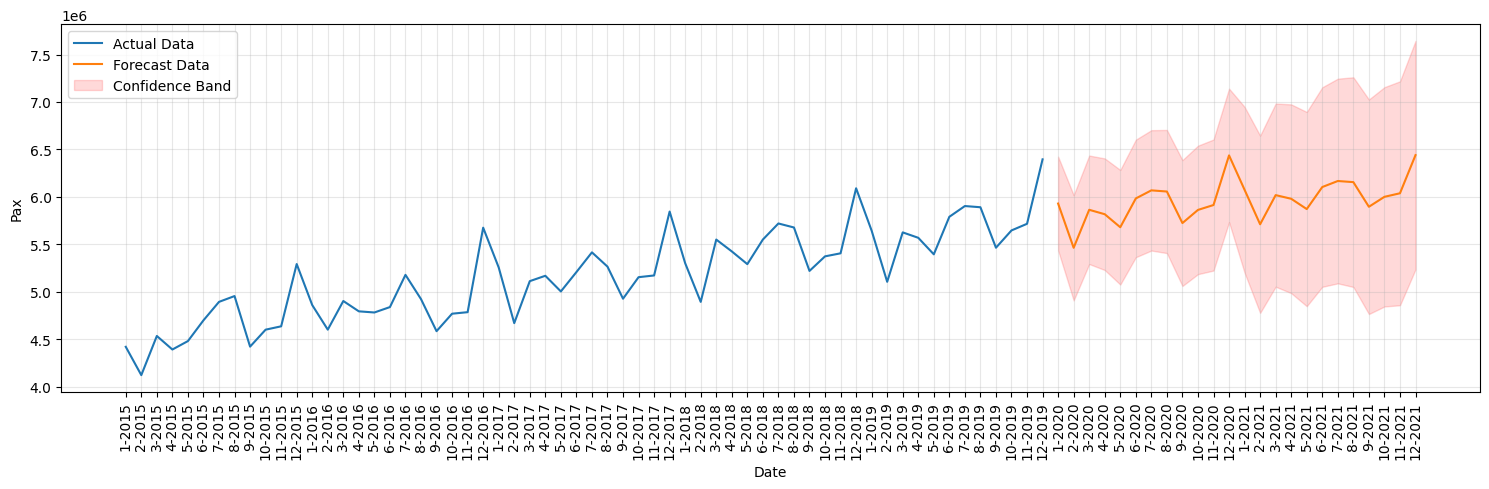

In [653]:
steps = 12 * 2
forecast_dates = [str(i)+'-'+str(j) for i in list(range(1,13)) for j in list(range(2020,2022))]

forecast = model_fit.get_forecast(steps=steps)
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

ax = df['Pax'].plot(figsize=(15,5))
forecast_values.plot()
# test['Pax'].plot(ax=ax)
plt.fill_between(forecast_values.index, 
                 confidence_intervals['lower Pax'], 
                 confidence_intervals['upper Pax'], 
                 color='red',
                 alpha=0.15)
plt.legend(['Actual Data', 
            'Forecast Data', 
            'Confidence Band'], 
           loc='upper left')

xlabels = list(df['Date']) + [str(i)+'-'+str(j) for j in list(range(2020,2022)) for i in list(range(1,13))]
xticks = np.arange(0, len(xlabels), 1)
ax.set_xticks(xticks, xlabels)
plt.xticks(rotation=90)

plt.xlabel('Date')
plt.ylabel('Pax')
plt.grid(alpha=0.3)
plt.tight_layout()